In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import time

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "mnist_continuous_alldigits/2/epoch_90_ckpt.pth")

In [5]:
# Define the branches
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in letters]
branch_defs = [(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'), 0.5235235235235235, 1), (('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5165165165165165, 0.5235235235235235), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5115115115115115, 0.5165165165165165), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4944944944944945, 0.5115115115115115), (('I', 'J'), 0.4794794794794795, 0.4944944944944945), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4724724724724725, 0.4944944944944945), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.45645645645645644, 0.4724724724724725), (('F', 'P', 'T', 'V', 'Y'), 0.4364364364364364, 0.4724724724724725), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.4174174174174174, 0.45645645645645644), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4134134134134134, 0.4174174174174174), (('B', 'D', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4094094094094094, 0.4134134134134134), (('F', 'T', 'V', 'Y'), 0.4024024024024024, 0.4364364364364364), (('B', 'D', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3863863863863864, 0.4094094094094094), (('B', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3813813813813814, 0.3863863863863864), (('B', 'G', 'H', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3733733733733734, 0.3813813813813814), (('F', 'T', 'Y'), 0.36036036036036034, 0.4024024024024024), (('C', 'E'), 0.3563563563563564, 0.4134134134134134), (('T', 'Y'), 0.3533533533533533, 0.36036036036036034), (('B', 'R', 'S', 'X', 'Z'), 0.35135135135135137, 0.3733733733733734), (('G', 'H', 'O', 'Q'), 0.34134134134134136, 0.3733733733733734), (('B', 'S', 'X', 'Z'), 0.32232232232232233, 0.35135135135135137), (('B', 'S', 'X'), 0.27627627627627627, 0.32232232232232233), (('G', 'H', 'O'), 0.26426426426426425, 0.34134134134134136), (('G', 'O'), 0.25725725725725723, 0.26426426426426425), (('S', 'X'), 0.15615615615615616, 0.27627627627627627), (('W',), 0, 0.5235235235235235), (('A',), 0, 0.5165165165165165), (('L',), 0, 0.5115115115115115), (('J',), 0, 0.4794794794794795), (('I',), 0, 0.4794794794794795), (('M',), 0, 0.45645645645645644), (('P',), 0, 0.4364364364364364), (('U',), 0, 0.4174174174174174), (('N',), 0, 0.4094094094094094), (('V',), 0, 0.4024024024024024), (('D',), 0, 0.3863863863863864), (('K',), 0, 0.3813813813813814), (('F',), 0, 0.36036036036036034), (('E',), 0, 0.3563563563563564), (('C',), 0, 0.3563563563563564), (('Y',), 0, 0.3533533533533533), (('T',), 0, 0.3533533533533533), (('R',), 0, 0.35135135135135137), (('Q',), 0, 0.34134134134134136), (('Z',), 0, 0.32232232232232233), (('B',), 0, 0.27627627627627627), (('H',), 0, 0.26426426426426425), (('G',), 0, 0.25725725725725723), (('O',), 0, 0.25725725725725723), (('S',), 0, 0.15615615615615616), (('X',), 0, 0.15615615615615616)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

input_shape = (16,)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/letters_efficiency"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [8]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import model

In [9]:
model = model_util.load_model(
    table_dnn.MultitaskTabularNet,
    os.path.join(models_base_path, "letters_continuous_allletters/1/epoch_100_ckpt.pth")
).to(DEVICE)

### Generating multiple digit classes

In [10]:
# Sample each class individually without taking advantage of branches
num_linear_trials = 10
linear_times = []
for _ in range(num_linear_trials):
    time_a = time.time()
    for class_to_sample in classes:
        print("Sampling class: %s" % class_to_letter[class_to_sample])
        generate.generate_continuous_branched_samples(
            model, sde, class_to_sample, class_time_to_branch_tensor,
            sampler="pc", t_limit=t_limit, num_steps=1000
        )
    time_b = time.time()
    time_taken = time_b - time_a
    linear_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f" % np.mean(linear_times))

Sampling class: A
Sampling class: B
Sampling class: C
Sampling class: D
Sampling class: E
Sampling class: F
Sampling class: G
Sampling class: H
Sampling class: I
Sampling class: J
Sampling class: K
Sampling class: L
Sampling class: M
Sampling class: N
Sampling class: O
Sampling class: P
Sampling class: Q
Sampling class: R
Sampling class: S
Sampling class: T
Sampling class: U
Sampling class: V
Sampling class: W
Sampling class: X
Sampling class: Y
Sampling class: Z
Total time taken: 91s
Sampling class: A
Sampling class: B
Sampling class: C
Sampling class: D
Sampling class: E
Sampling class: F
Sampling class: G
Sampling class: H
Sampling class: I
Sampling class: J
Sampling class: K
Sampling class: L
Sampling class: M
Sampling class: N
Sampling class: O
Sampling class: P
Sampling class: Q
Sampling class: R
Sampling class: S
Sampling class: T
Sampling class: U
Sampling class: V
Sampling class: W
Sampling class: X
Sampling class: Y
Sampling class: Z
Total time taken: 90s
Sampling class: A
Sa

In [11]:
# Sample each digit by taking advantage of branches
num_branched_trials = 10
branched_times = []

# Sort the branches by starting time point (in reverse order), and generate along those
# branches, caching results; this guarantees that we will always find a cached batch
# (other than the first one)
cache = {}
sorted_branch_defs = sorted(branch_defs, key=(lambda t: -t[1]))

for _ in range(num_branched_trials):
    time_a = time.time()
    # First branch
    print("Sampling branch 1/%d" % len(sorted_branch_defs))
    branch_def = sorted_branch_defs[0]
    samples = generate.generate_continuous_branched_samples(
        # Specify arbitrary class
        model, sde, branch_def[0][0], class_time_to_branch_tensor,
        sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
        num_steps=int(1000 * (branch_def[2] - branch_def[1]))
    )
    for class_i in branch_def[0]:
        cache[class_i] = (branch_def[1], samples)

    for i, branch_def in enumerate(sorted_branch_defs[1:]):
        print("Sampling branch %d/%d" % (i + 2, len(sorted_branch_defs)))
        cached_time, cached_samples = cache[branch_def[0][0]]
        assert cached_time == branch_def[2]
        samples = generate.generate_continuous_branched_samples(
            model, sde, branch_def[0][0], class_time_to_branch_tensor,
            sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
            num_steps=int(1000 * (branch_def[2] - branch_def[1])),
            initial_samples=cached_samples
        )
        for class_i in branch_def[0]:
            cache[class_i] = (branch_def[1], samples)

    time_b = time.time()
    time_taken = time_b - time_a
    branched_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f" % np.mean(branched_times))

Sampling branch 1/51
Sampling branch 2/51
Sampling branch 3/51
Sampling branch 4/51
Sampling branch 5/51
Sampling branch 6/51
Sampling branch 7/51
Sampling branch 8/51
Sampling branch 9/51
Sampling branch 10/51
Sampling branch 11/51
Sampling branch 12/51
Sampling branch 13/51
Sampling branch 14/51
Sampling branch 15/51
Sampling branch 16/51
Sampling branch 17/51
Sampling branch 18/51
Sampling branch 19/51
Sampling branch 20/51
Sampling branch 21/51
Sampling branch 22/51
Sampling branch 23/51
Sampling branch 24/51
Sampling branch 25/51
Sampling branch 26/51
Sampling branch 27/51
Sampling branch 28/51
Sampling branch 29/51
Sampling branch 30/51
Sampling branch 31/51
Sampling branch 32/51
Sampling branch 33/51
Sampling branch 34/51
Sampling branch 35/51
Sampling branch 36/51
Sampling branch 37/51
Sampling branch 38/51
Sampling branch 39/51
Sampling branch 40/51
Sampling branch 41/51
Sampling branch 42/51
Sampling branch 43/51
Sampling branch 44/51
Sampling branch 45/51
Sampling branch 46/

Sampling branch 13/51
Sampling branch 14/51
Sampling branch 15/51
Sampling branch 16/51
Sampling branch 17/51
Sampling branch 18/51
Sampling branch 19/51
Sampling branch 20/51
Sampling branch 21/51
Sampling branch 22/51
Sampling branch 23/51
Sampling branch 24/51
Sampling branch 25/51
Sampling branch 26/51
Sampling branch 27/51
Sampling branch 28/51
Sampling branch 29/51
Sampling branch 30/51
Sampling branch 31/51
Sampling branch 32/51
Sampling branch 33/51
Sampling branch 34/51
Sampling branch 35/51
Sampling branch 36/51
Sampling branch 37/51
Sampling branch 38/51
Sampling branch 39/51
Sampling branch 40/51
Sampling branch 41/51
Sampling branch 42/51
Sampling branch 43/51
Sampling branch 44/51
Sampling branch 45/51
Sampling branch 46/51
Sampling branch 47/51
Sampling branch 48/51
Sampling branch 49/51
Sampling branch 50/51
Sampling branch 51/51
Total time taken: 54s
Sampling branch 1/51
Sampling branch 2/51
Sampling branch 3/51
Sampling branch 4/51
Sampling branch 5/51
Sampling branch

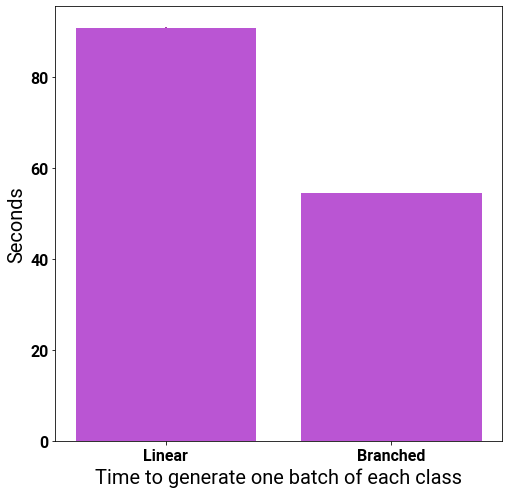

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
labels = ["Linear", "Branched"]
times = [np.mean(linear_times), np.mean(branched_times)]
errors = [np.std(linear_times) / np.sqrt(num_linear_trials), np.std(branched_times) / np.sqrt(num_branched_trials)]
ax.bar(labels, times, color="mediumorchid")
ax.errorbar(labels, times, yerr=errors, fmt="none", color="darkmagenta")
ax.set_xlabel("Time to generate one batch of each class")
ax.set_ylabel("Seconds")
plt.show()
fig.savefig(
    os.path.join(out_path, "letters_efficiency.svg"),
    format="svg"
)